In [1]:
# 1) Environment setup
!pip install pyspark findspark matplotlib seaborn pandas

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 32.9 MB/s eta 0:00:00


In [1]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import lit, length, col, count, when, isnan
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType, FloatType
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

Matplotlib created a temporary cache directory at /scratch/nalo/job_39155735/matplotlib-09oqe4c4 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "20g") \
    .config("spark.executor.memory", "20g") \
    .config('spark.executor.instances', 2) \
    .getOrCreate()

In [3]:
# Load data in

folder_path = "/expanse/lustre/projects/uci150/mzidell/reviews_parquet"
all_files = os.listdir(folder_path)
parquet_files = [f for f in all_files if f.endswith('.parquet')]

all_df = []
for file in parquet_files:
    file_path = os.path.join(folder_path, file)
    category = file.strip('review_').strip('.parquet')
    df = sc.read.parquet(file_path).withColumn("category", lit(category))
    all_df.append(df)
    print(f"Loaded: {file}")

reviews = reduce(DataFrame.unionByName, all_df)

Loaded: review_Cell_Phones_and_Accessories.parquet
Loaded: review_Grocery_and_Gourmet_Food.parquet
Loaded: review_Health_and_Personal_Care.parquet
Loaded: review_Arts_Crafts_and_Sewing.parquet
Loaded: review_Pet_Supplies.parquet
Loaded: review_Toys_and_Games.parquet
Loaded: review_Industrial_and_Scientific.parquet
Loaded: review_Patio_Lawn_and_Garden.parquet
Loaded: review_Movies_and_TV.parquet
Loaded: review_Gift_Cards.parquet
Loaded: review_Video_Games.parquet
Loaded: review_Tools_and_Home_Improvement.parquet
Loaded: review_Office_Products.parquet
Loaded: review_Digital_Music.parquet
Loaded: review_Automotive.parquet
Loaded: review_Sports_and_Outdoors.parquet
Loaded: review_All_Beauty.parquet
Loaded: review_Musical_Instruments.parquet
Loaded: review_Amazon_Fashion.parquet
Loaded: review_CDs_and_Vinyl.parquet
Loaded: review_Kindle_Store.parquet
Loaded: review_Magazine_Subscriptions.parquet
Loaded: review_Beauty_and_Personal_Care.parquet
Loaded: review_Health_and_Household.parquet
Load

In [5]:
# 3.1 Shape & Schema
print(f"Total reviews: {reviews.count()}")
reviews.printSchema()

# 3.2 Missing / Null counts per column
def null_counts(df):
    numeric_types = (DoubleType, FloatType)
    return df.select([
        count(when(col(f.name).isNull() | (isnan(col(f.name)) if isinstance(f.dataType, numeric_types) else F.lit(False)), f.name)).alias(f.name)
        for f in df.schema.fields
    ])

print("Review nulls:")
null_counts(reviews).show()

# 3.3 Summary statistics (numeric & string lengths)
reviews.select("rating").describe().show()

# add a text-length column
reviews = reviews.withColumn("text_len", length(col("text")))
reviews.select("text_len").describe().show()

# 3.4 Value counts: rating & verified_purchase
reviews.groupBy("rating").count().orderBy("rating").show()
reviews.groupBy("verified_purchase").count().show()

Total reviews: 300260938
root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- category: string (nullable = false)

Review nulls:
+------+-----+----+------+----+-----------+-------+---------+------------+-----------------+--------+
|rating|title|text|images|asin|parent_asin|user_id|timestamp|helpful_vote|verified_purchase|category|
+------+-----+----+------+----+-----

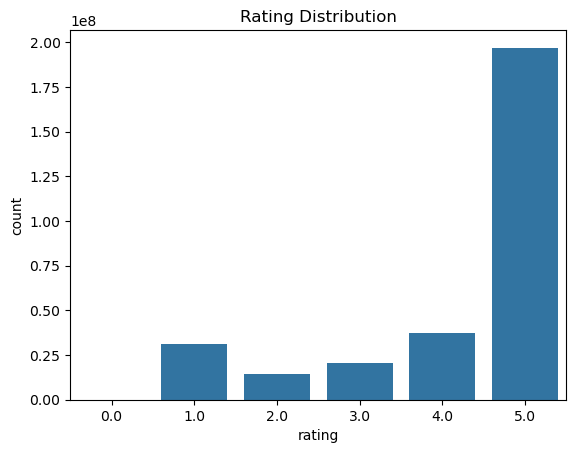

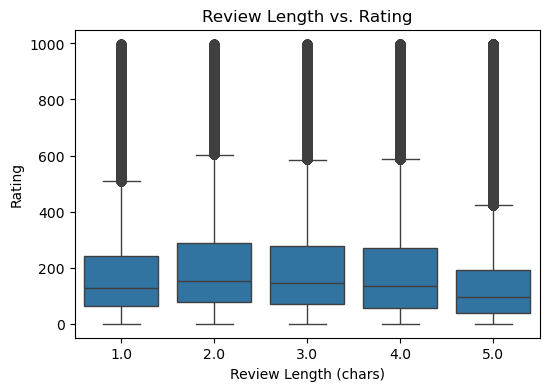

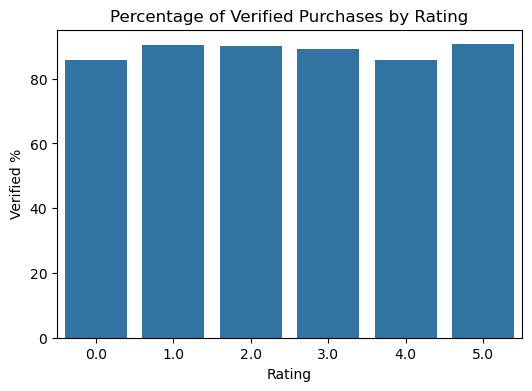

In [10]:
# Ratings histogram
pdf = reviews.groupBy("rating") \
    .count() \
    .orderBy("rating") \
    .toPandas()
sns.barplot(x="rating", y="count", data=pdf)
plt.title("Rating Distribution")
plt.show()

# Box Plot: Review length vs. Rating
scatter_pdf = reviews.select("text_len","rating") \
      .dropna() \
      .sample(False, 0.01, seed=1) \
      .filter(reviews.text_len < 1000) \
      .toPandas()
plt.figure(figsize=(6,4))
sns.boxplot(x='rating', y='text_len', data=scatter_pdf)
plt.xlabel("Review Length (chars)")
plt.ylabel("Rating")
plt.title("Review Length vs. Rating")
plt.show()

# Verified vs. Unverified Purchase Ratings
# Step 1: Count total reviews per rating
total_counts = reviews.groupBy("rating").count().withColumnRenamed("count", "total")
# Step 2: Count verified reviews per rating
verified_counts = reviews.filter(F.col("verified_purchase") == "Y") \
                         .groupBy("rating") \
                         .count() \
                         .withColumnRenamed("count", "verified")
# Step 3: Join and compute percentage
percent_df = verified_counts.join(total_counts, on="rating") \
                            .withColumn("percent_verified", (F.col("verified") / F.col("total")) * 100)
# Optional: Convert to Pandas and plot
plot_df = percent_df.select("rating", "percent_verified").toPandas()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x="rating", y="percent_verified", data=plot_df)
plt.title("Percentage of Verified Purchases by Rating")
plt.ylabel("Verified %")
plt.xlabel("Rating")
plt.show()

Link to download data (All_Beauty category only for now): https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz